In [1]:
# Cell 1: Setup and Initialize ML Environment
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb
import pickle
import joblib

print("🤖 PUNJAB SMART CROP ADVISORY - MACHINE LEARNING MODEL TRAINING")
print("=" * 70)
print(f"📅 Training Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🎯 Goal: Train ML models to predict crop yields for Punjab farmers")

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


🤖 PUNJAB SMART CROP ADVISORY - MACHINE LEARNING MODEL TRAINING
📅 Training Date: 2025-09-01 03:11:18
🎯 Goal: Train ML models to predict crop yields for Punjab farmers


In [2]:
# Cell 2: Load and Prepare Dataset
print("\n📂 LOADING PROCESSED DATASET")
print("=" * 32)

try:
    # Load the feature-engineered dataset
    master_df = pd.read_csv('../data/processed/master_dataset_final_engineered.csv')
    
    print(f"✅ Dataset loaded successfully:")
    print(f"   📊 Shape: {master_df.shape[0]} rows × {master_df.shape[1]} columns")
    print(f"   🎯 Target: yield_kg_per_hectare")
    
    # Display basic statistics
    print(f"\n📈 Target Variable Statistics:")
    target_stats = master_df['yield_kg_per_hectare'].describe()
    print(f"   Mean: {target_stats['mean']:.1f} kg/ha")
    print(f"   Median: {target_stats['50%']:.1f} kg/ha")
    print(f"   Std: {target_stats['std']:.1f} kg/ha")
    print(f"   Range: {target_stats['min']:.1f} - {target_stats['max']:.1f} kg/ha")
    
    # Check data quality
    missing_count = master_df.isnull().sum().sum()
    print(f"\n🔍 Data Quality:")
    print(f"   Missing values: {missing_count}")
    print(f"   Duplicate rows: {master_df.duplicated().sum()}")
    
except FileNotFoundError:
    print("❌ Dataset not found. Please run 02_Feature_Engineering_EDA.ipynb first")
    sys.exit(1)



📂 LOADING PROCESSED DATASET
✅ Dataset loaded successfully:
   📊 Shape: 450 rows × 43 columns
   🎯 Target: yield_kg_per_hectare

📈 Target Variable Statistics:
   Mean: 3296.0 kg/ha
   Median: 3954.8 kg/ha
   Std: 2138.5 kg/ha
   Range: 307.2 - 8102.6 kg/ha

🔍 Data Quality:
   Missing values: 0
   Duplicate rows: 0


In [3]:
# Cell 3: Feature Selection and Data Preparation
print("\n🛠️ FEATURE SELECTION & DATA PREPARATION")
print("=" * 42)

def prepare_ml_dataset(df):
    """Prepare dataset for machine learning"""
    
    print("🔄 Preparing dataset for ML training...")
    
    # Create a copy for processing
    ml_df = df.copy()
    
    # Define feature categories
    target_col = 'yield_kg_per_hectare'
    
    # Columns to exclude from features
    exclude_cols = [
        'plot_id', 'sowing_date', 'harvest_date', 
        target_col
    ]
    
    # Identify categorical columns that need encoding
    categorical_cols = []
    for col in ml_df.columns:
        if ml_df[col].dtype == 'object' and col not in exclude_cols:
            categorical_cols.append(col)
    
    print(f"📋 Found {len(categorical_cols)} categorical columns to encode: {categorical_cols}")
    
    # Encode categorical variables
    label_encoders = {}
    for col in categorical_cols:
        if col in ml_df.columns:
            le = LabelEncoder()
            ml_df[f'{col}_encoded'] = le.fit_transform(ml_df[col].astype(str))
            label_encoders[col] = le
            print(f"   ✅ Encoded {col}: {len(le.classes_)} unique values")
    
    # Select features for training
    feature_cols = []
    for col in ml_df.columns:
        if col not in exclude_cols and col not in categorical_cols:
            feature_cols.append(col)
    
    print(f"\n📊 Selected {len(feature_cols)} features for training")
    
    # Create feature matrix and target vector
    X = ml_df[feature_cols]
    y = ml_df[target_col]
    
    # Handle missing values
    print(f"🔧 Handling missing values...")
    missing_before = X.isnull().sum().sum()
    print(f"   Missing values before: {missing_before}")
    
    # Fill missing values with median for numeric columns
    for col in X.columns:
        if X[col].dtype in ['float64', 'int64']:
            X[col] = X[col].fillna(X[col].median())
        else:
            X[col] = X[col].fillna(X[col].mode()[0] if len(X[col].mode()) > 0 else 0)
    
    missing_after = X.isnull().sum().sum()
    print(f"   Missing values after: {missing_after}")
    
    print(f"\n✅ Dataset prepared: {len(X)} samples × {len(feature_cols)} features")
    
    return X, y, feature_cols, label_encoders

# Prepare the dataset
X, y, feature_names, encoders = prepare_ml_dataset(master_df)

# Display feature summary
print(f"\n📋 Feature Summary:")
numeric_features = X.select_dtypes(include=[np.number]).columns
print(f"   Numeric features: {len(numeric_features)}")
print(f"   Total features: {len(feature_names)}")



🛠️ FEATURE SELECTION & DATA PREPARATION
🔄 Preparing dataset for ML training...
📋 Found 8 categorical columns to encode: ['crop_type', 'district', 'data_source', 'soil_health_status', 'data_source_soil', 'data_source_weather', 'soil_pH_category', 'season']
   ✅ Encoded crop_type: 3 unique values
   ✅ Encoded district: 8 unique values
   ✅ Encoded data_source: 1 unique values
   ✅ Encoded soil_health_status: 3 unique values
   ✅ Encoded data_source_soil: 3 unique values
   ✅ Encoded data_source_weather: 1 unique values
   ✅ Encoded soil_pH_category: 3 unique values
   ✅ Encoded season: 2 unique values

📊 Selected 39 features for training
🔧 Handling missing values...
   Missing values before: 0
   Missing values after: 0

✅ Dataset prepared: 450 samples × 39 features

📋 Feature Summary:
   Numeric features: 39
   Total features: 39


In [4]:
# Cell 4: Train-Test Split Strategy
print(f"\n📊 TRAIN-TEST SPLIT STRATEGY")
print("=" * 32)

# Use stratified split based on crop type if available
if 'crop_type' in master_df.columns:
    # Get crop type for stratification
    crop_types = master_df.loc[X.index, 'crop_type']
    
    # Stratified split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=crop_types
    )
    print("✅ Using stratified split based on crop type")
else:
    # Regular random split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print("✅ Using random split")

print(f"\n📊 Split Results:")
print(f"   Training samples: {len(X_train):,}")
print(f"   Test samples: {len(X_test):,}")
print(f"   Features: {X_train.shape[1]}")

# Target distribution analysis
print(f"\n📈 Target Distribution:")
print(f"   Training - Mean: {y_train.mean():.1f}, Std: {y_train.std():.1f}")
print(f"   Test - Mean: {y_test.mean():.1f}, Std: {y_test.std():.1f}")

# Feature scaling for certain algorithms
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Features scaled for linear models")



📊 TRAIN-TEST SPLIT STRATEGY
✅ Using stratified split based on crop type

📊 Split Results:
   Training samples: 360
   Test samples: 90
   Features: 39

📈 Target Distribution:
   Training - Mean: 3311.9, Std: 2151.8
   Test - Mean: 3232.5, Std: 2095.3
✅ Features scaled for linear models


In [5]:
# Cell 5: Model Training and Evaluation
print(f"\n🏋️ COMPREHENSIVE MODEL TRAINING")
print("=" * 35)

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, use_scaling=False):
    """Train and evaluate a machine learning model"""
    
    print(f"\n🔄 Training {model_name}...")
    
    # Select appropriate data
    if use_scaling:
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test
    
    # Train the model
    model.fit(X_train_model, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train_model)
    y_test_pred = model.predict(X_test_model)
    
    # Calculate metrics
    metrics = {
        'model_name': model_name,
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'test_mae': mean_absolute_error(y_test, y_test_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'train_r2': r2_score(y_train, y_train_pred),
        'test_r2': r2_score(y_test, y_test_pred),
        'model': model
    }
    
    # Cross-validation score
    try:
        cv_scores = cross_val_score(model, X_train_model, y_train, cv=5, scoring='r2')
        metrics['cv_r2_mean'] = cv_scores.mean()
        metrics['cv_r2_std'] = cv_scores.std()
    except:
        metrics['cv_r2_mean'] = np.nan
        metrics['cv_r2_std'] = np.nan
    
    print(f"   ✅ {model_name} - R² Score: {metrics['test_r2']:.3f}, RMSE: {metrics['test_rmse']:.1f}")
    
    return metrics

# Define models to train
models = {
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ),
    
    'XGBoost': xgb.XGBRegressor(
        n_estimators=100,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ),
    
    'LightGBM': lgb.LGBMRegressor(
        n_estimators=100,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    ),
    
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=100,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42
    ),
    
    'Extra Trees': ExtraTreesRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    ),
    
    'Ridge Regression': Ridge(alpha=1.0),
    
    'Linear Regression': LinearRegression()
}

# Train and evaluate all models
results = []
trained_models = {}

print("🚀 Starting model training pipeline...")

for name, model in models.items():
    try:
        # Determine if scaling is needed
        use_scaling = name in ['Ridge Regression', 'Linear Regression', 'Lasso', 'ElasticNet']
        
        # Train and evaluate
        metrics = evaluate_model(model, X_train, X_test, y_train, y_test, name, use_scaling)
        results.append(metrics)
        
        # Store model with scaling info
        trained_models[name] = {
            'model': model,
            'use_scaling': use_scaling,
            'scaler': scaler if use_scaling else None
        }
        
    except Exception as e:
        print(f"   ❌ {name} failed: {e}")

print(f"\n✅ Model training completed! {len(results)} models trained successfully.")



🏋️ COMPREHENSIVE MODEL TRAINING
🚀 Starting model training pipeline...

🔄 Training Random Forest...
   ✅ Random Forest - R² Score: 0.961, RMSE: 411.1

🔄 Training XGBoost...
   ✅ XGBoost - R² Score: 0.948, RMSE: 477.1

🔄 Training LightGBM...
   ✅ LightGBM - R² Score: 0.955, RMSE: 441.3

🔄 Training Gradient Boosting...
   ✅ Gradient Boosting - R² Score: 0.952, RMSE: 455.2

🔄 Training Extra Trees...
   ✅ Extra Trees - R² Score: 0.955, RMSE: 440.9

🔄 Training Ridge Regression...
   ✅ Ridge Regression - R² Score: 0.944, RMSE: 495.2

🔄 Training Linear Regression...
   ✅ Linear Regression - R² Score: 0.943, RMSE: 496.2

✅ Model training completed! 7 models trained successfully.



📊 MODEL PERFORMANCE COMPARISON
🏆 Model Performance Ranking:
Rank Model                Test R²    Test RMSE    Test MAE   CV R²          
----------------------------------------------------------------------
1    Random Forest        0.961      411.1        269.8      0.955±0.009    
2    Extra Trees          0.955      440.9        296.9      0.942±0.011    
3    LightGBM             0.955      441.3        298.8      0.951±0.011    
4    Gradient Boosting    0.952      455.2        305.8      0.939±0.011    
5    XGBoost              0.948      477.1        330.7      0.938±0.012    
6    Ridge Regression     0.944      495.2        406.6      0.933±0.008    
7    Linear Regression    0.943      496.2        408.3      0.932±0.008    

🥇 Best Model: Random Forest
   R² Score: 0.961
   RMSE: 411.1 kg/hectare


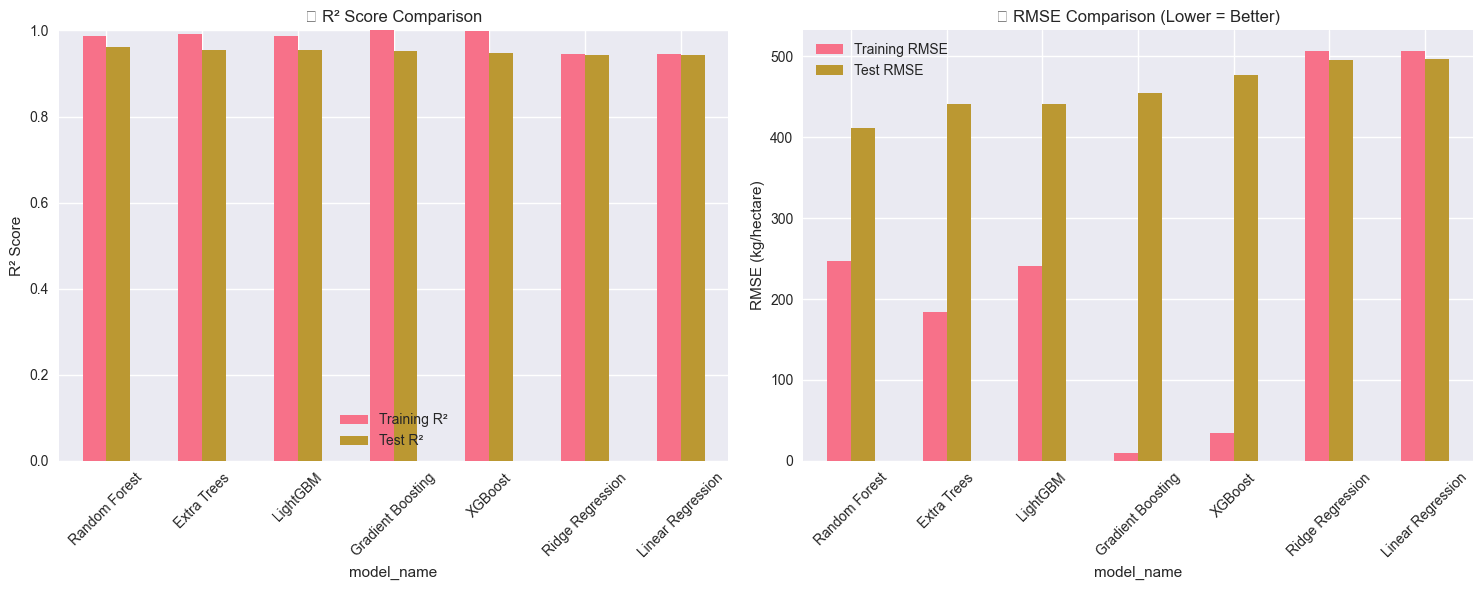

In [6]:
# Cell 6: Model Performance Comparison
print(f"\n📊 MODEL PERFORMANCE COMPARISON")
print("=" * 35)

# Create results DataFrame
results_df = pd.DataFrame(results)

if len(results_df) > 0:
    # Sort by test R² score
    results_df = results_df.sort_values('test_r2', ascending=False)
    
    print("🏆 Model Performance Ranking:")
    print("=" * 70)
    print(f"{'Rank':<4} {'Model':<20} {'Test R²':<10} {'Test RMSE':<12} {'Test MAE':<10} {'CV R²':<15}")
    print("-" * 70)
    
    for idx, (_, row) in enumerate(results_df.iterrows(), 1):
        cv_score = f"{row['cv_r2_mean']:.3f}±{row['cv_r2_std']:.3f}" if not np.isnan(row['cv_r2_mean']) else "N/A"
        print(f"{idx:<4} {row['model_name']:<20} "
              f"{row['test_r2']:<10.3f} "
              f"{row['test_rmse']:<12.1f} "
              f"{row['test_mae']:<10.1f} "
              f"{cv_score:<15}")
    
    # Get best model
    best_model_name = results_df.iloc[0]['model_name']
    best_model_r2 = results_df.iloc[0]['test_r2']
    best_model_rmse = results_df.iloc[0]['test_rmse']
    
    print(f"\n🥇 Best Model: {best_model_name}")
    print(f"   R² Score: {best_model_r2:.3f}")
    print(f"   RMSE: {best_model_rmse:.1f} kg/hectare")
    
    # Visualize model comparison
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # R² Score comparison
    results_df.plot(x='model_name', y=['train_r2', 'test_r2'], kind='bar', ax=axes[0])
    axes[0].set_title('🎯 R² Score Comparison')
    axes[0].set_ylabel('R² Score')
    axes[0].legend(['Training R²', 'Test R²'])
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].set_ylim(0, 1)
    
    # RMSE comparison
    results_df.plot(x='model_name', y=['train_rmse', 'test_rmse'], kind='bar', ax=axes[1])
    axes[1].set_title('📊 RMSE Comparison (Lower = Better)')
    axes[1].set_ylabel('RMSE (kg/hectare)')
    axes[1].legend(['Training RMSE', 'Test RMSE'])
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('../data/processed/model_performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

else:
    print("❌ No models trained successfully")



🔍 FEATURE IMPORTANCE ANALYSIS

🏆 Top 15 Features - Random Forest:
---------------------------------------------
  0.8832 : crop_type_encoded
  0.0301 : latitude
  0.0155 : soil_health_status_encoded
  0.0129 : data_source_soil_encoded
  0.0124 : sowing_day_of_year
  0.0119 : rainfall
  0.0074 : is_kharif
  0.0039 : season_encoded
  0.0026 : sowing_month
  0.0026 : year
  0.0024 : is_rabi
  0.0024 : K_available
  0.0016 : N_K_ratio
  0.0013 : temperature
  0.0012 : organic_carbon


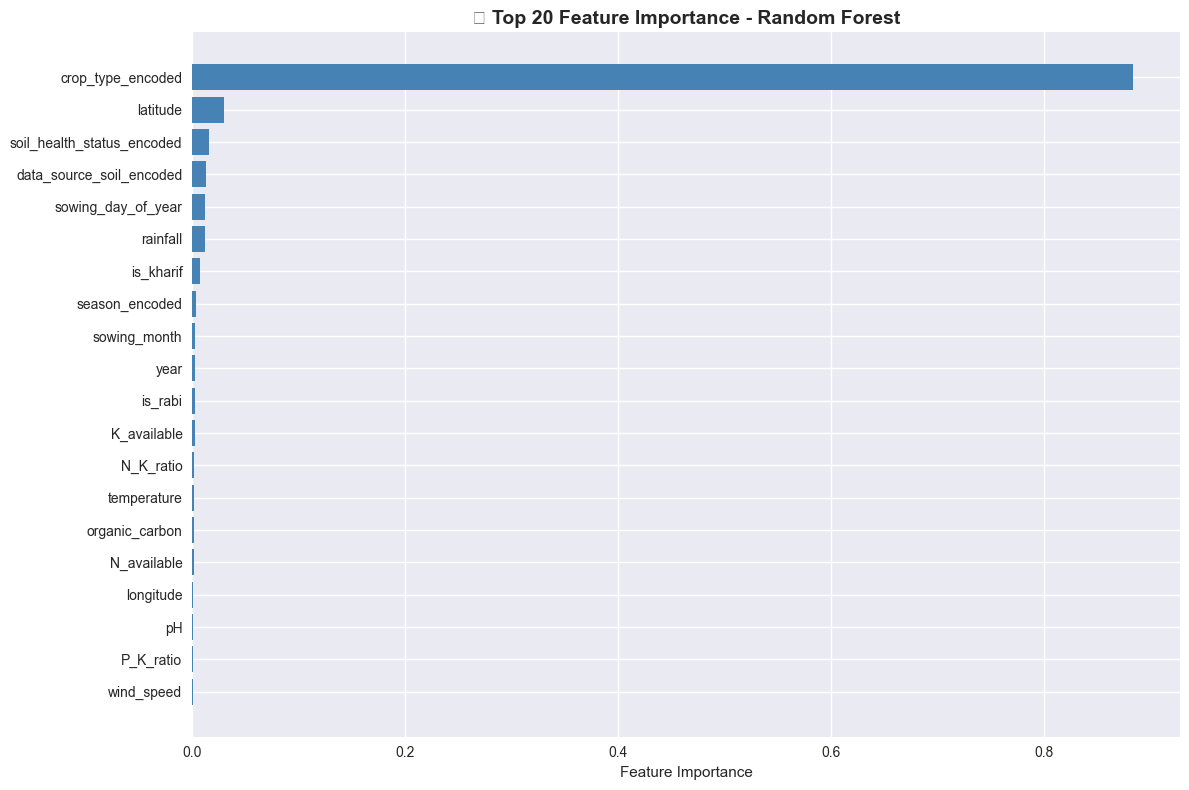

In [7]:
# Cell 7: Feature Importance Analysis
print(f"\n🔍 FEATURE IMPORTANCE ANALYSIS")
print("=" * 32)

def analyze_feature_importance(model_name, model, feature_names):
    """Analyze and visualize feature importance"""
    
    if hasattr(model, 'feature_importances_'):
        # Tree-based models
        importances = model.feature_importances_
        
        # Create importance DataFrame
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print(f"\n🏆 Top 15 Features - {model_name}:")
        print("-" * 45)
        for idx, row in importance_df.head(15).iterrows():
            print(f"{row['importance']:>8.4f} : {row['feature']}")
        
        # Visualize top 20 features
        plt.figure(figsize=(12, 8))
        top_features = importance_df.head(20)
        
        plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'🏆 Top 20 Feature Importance - {model_name}', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig(f'../data/processed/feature_importance_{model_name.lower().replace(" ", "_")}.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()
        
        return importance_df
    
    else:
        print(f"⚠️ {model_name} does not support feature importance")
        return None

# Analyze feature importance for best tree-based models
tree_models = ['Random Forest', 'XGBoost', 'LightGBM', 'Gradient Boosting', 'Extra Trees']

for model_name in tree_models:
    if model_name in trained_models:
        model = trained_models[model_name]['model']
        importance_df = analyze_feature_importance(model_name, model, feature_names)
        
        if importance_df is not None:
            # Save feature importance
            importance_df.to_csv(f'../data/processed/feature_importance_{model_name.lower().replace(" ", "_")}.csv', 
                               index=False)
        break  # Analyze only the first available model


In [8]:
# Cell 8: Hyperparameter Tuning for Best Model
print(f"\n🎛️ HYPERPARAMETER TUNING")
print("=" * 25)

if len(results_df) > 0:
    best_model_name = results_df.iloc[0]['model_name']
    print(f"🎯 Tuning hyperparameters for: {best_model_name}")
    
    # Define parameter grids
    param_grids = {
        'Random Forest': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 15, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        },
        
        'XGBoost': {
            'n_estimators': [100, 200, 300],
            'max_depth': [6, 8, 10],
            'learning_rate': [0.05, 0.1, 0.15],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        },
        
        'LightGBM': {
            'n_estimators': [100, 200, 300],
            'max_depth': [6, 8, 10],
            'learning_rate': [0.05, 0.1, 0.15],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        }
    }
    
    # Perform hyperparameter tuning if grid is available
    if best_model_name in param_grids:
        print(f"🔄 Running RandomizedSearchCV for {best_model_name}...")
        
        # Get base model
        base_model = trained_models[best_model_name]['model']
        param_grid = param_grids[best_model_name]
        
        # Create fresh model instance
        if best_model_name == 'Random Forest':
            fresh_model = RandomForestRegressor(random_state=42, n_jobs=-1)
        elif best_model_name == 'XGBoost':
            fresh_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)
        elif best_model_name == 'LightGBM':
            fresh_model = lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1)
        
        # Randomized search (faster than GridSearch)
        random_search = RandomizedSearchCV(
            fresh_model,
            param_grid,
            n_iter=20,  # Number of parameter settings sampled
            cv=5,
            scoring='r2',
            n_jobs=-1,
            random_state=42,
            verbose=1
        )
        
        # Fit the search
        random_search.fit(X_train, y_train)
        
        # Get best model
        tuned_model = random_search.best_estimator_
        
        print(f"✅ Best parameters found:")
        for param, value in random_search.best_params_.items():
            print(f"   {param}: {value}")
        
        # Evaluate tuned model
        tuned_metrics = evaluate_model(tuned_model, X_train, X_test, y_train, y_test, 
                                     f"{best_model_name}_Tuned", use_scaling=False)
        
        print(f"\n📊 Performance Comparison:")
        print(f"   Original Model - R²: {best_model_r2:.3f}")
        print(f"   Tuned Model    - R²: {tuned_metrics['test_r2']:.3f}")
        print(f"   Improvement: {tuned_metrics['test_r2'] - best_model_r2:+.3f}")
        
        # Use tuned model if better
        if tuned_metrics['test_r2'] > best_model_r2:
            final_model = tuned_model
            final_model_name = f"{best_model_name}_Tuned"
            final_metrics = tuned_metrics
            print(f"✅ Using tuned model as final model!")
        else:
            final_model = trained_models[best_model_name]['model']
            final_model_name = best_model_name
            final_metrics = results_df.iloc[0].to_dict()
            print(f"⚠️ Original model performs better, keeping original")
    
    else:
        final_model = trained_models[best_model_name]['model']
        final_model_name = best_model_name
        final_metrics = results_df.iloc[0].to_dict()
        print(f"ℹ️ No hyperparameter tuning available for {best_model_name}")

else:
    print("❌ No models available for tuning")



🎛️ HYPERPARAMETER TUNING
🎯 Tuning hyperparameters for: Random Forest
🔄 Running RandomizedSearchCV for Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Best parameters found:
   n_estimators: 100
   min_samples_split: 2
   min_samples_leaf: 2
   max_features: None
   max_depth: 15

🔄 Training Random Forest_Tuned...
   ✅ Random Forest_Tuned - R² Score: 0.961, RMSE: 412.2

📊 Performance Comparison:
   Original Model - R²: 0.961
   Tuned Model    - R²: 0.961
   Improvement: -0.000
⚠️ Original model performs better, keeping original



✅ FINAL MODEL VALIDATION & ANALYSIS
🏆 FINAL MODEL PERFORMANCE:
   Model: Random Forest
   Training R²: 0.987
   Test R²: 0.961
   Test MAE: 269.8 kg/hectare
   Test RMSE: 411.1 kg/hectare


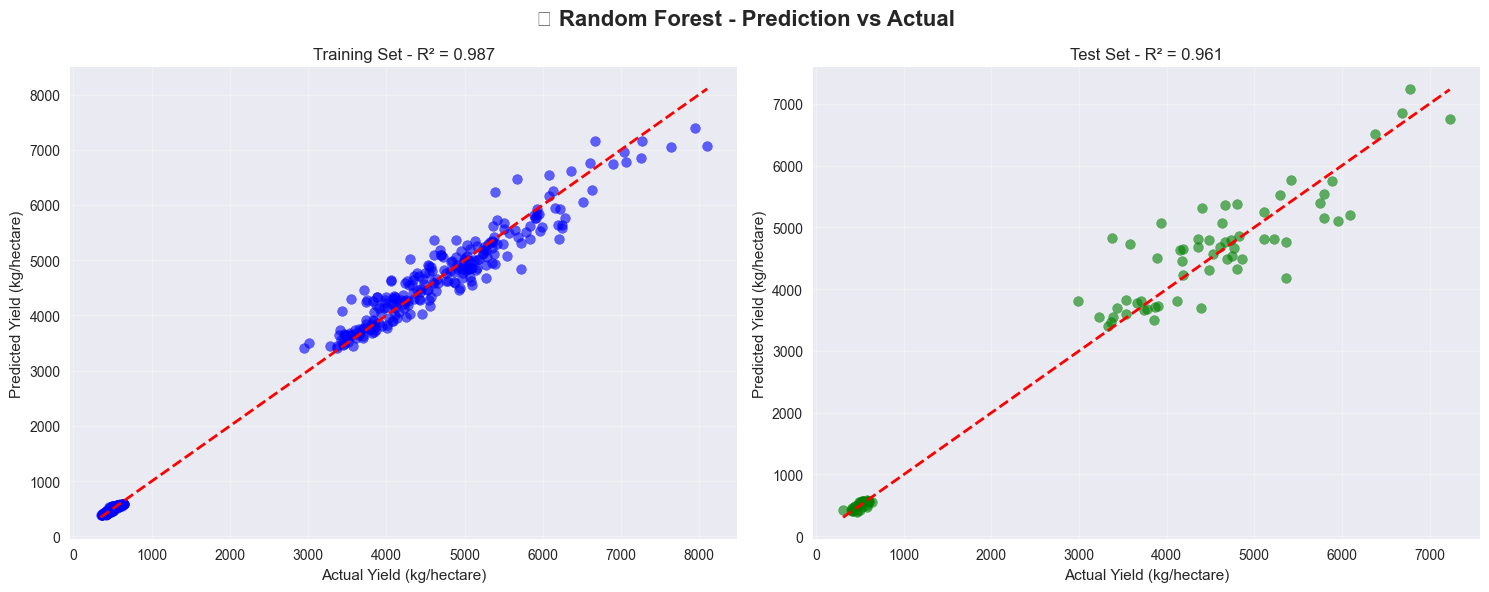

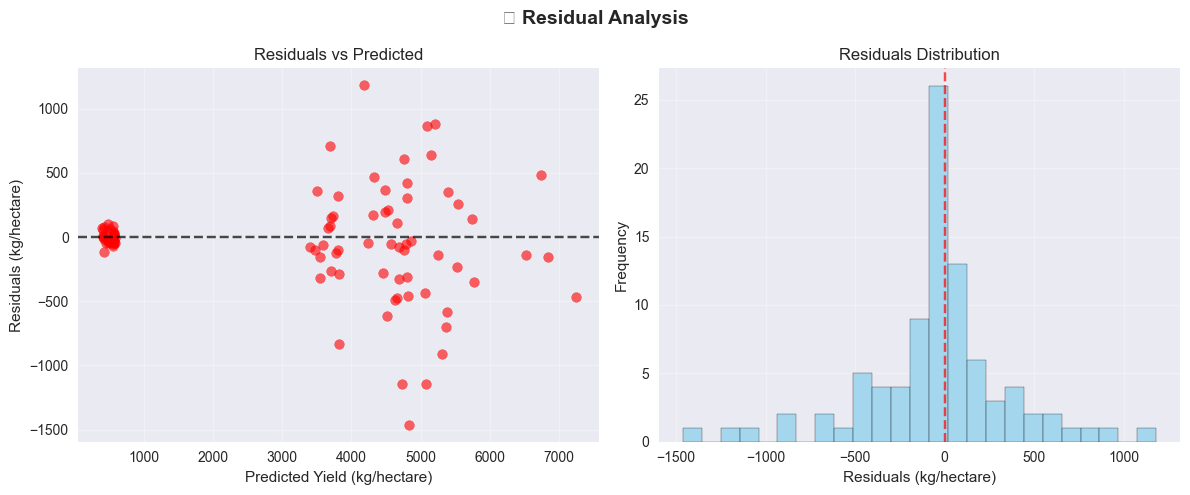

In [9]:
# Cell 9: Model Validation and Prediction Analysis
print(f"\n✅ FINAL MODEL VALIDATION & ANALYSIS")
print("=" * 40)

if len(results_df) > 0:
    # Make predictions with final model
    if 'final_model' in locals():
        model_to_use = final_model
        model_name_to_use = final_model_name
    else:
        model_to_use = trained_models[best_model_name]['model']
        model_name_to_use = best_model_name
    
    # Get predictions
    y_pred_train = model_to_use.predict(X_train)
    y_pred_test = model_to_use.predict(X_test)
    
    # Calculate final metrics
    final_train_mae = mean_absolute_error(y_train, y_pred_train)
    final_test_mae = mean_absolute_error(y_test, y_pred_test)
    final_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    final_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    final_train_r2 = r2_score(y_train, y_pred_train)
    final_test_r2 = r2_score(y_test, y_pred_test)
    
    print(f"🏆 FINAL MODEL PERFORMANCE:")
    print(f"   Model: {model_name_to_use}")
    print(f"   Training R²: {final_train_r2:.3f}")
    print(f"   Test R²: {final_test_r2:.3f}")
    print(f"   Test MAE: {final_test_mae:.1f} kg/hectare")
    print(f"   Test RMSE: {final_test_rmse:.1f} kg/hectare")
    
    # Prediction vs Actual plots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Training set
    axes[0].scatter(y_train, y_pred_train, alpha=0.6, color='blue', s=50)
    axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
    axes[0].set_xlabel('Actual Yield (kg/hectare)')
    axes[0].set_ylabel('Predicted Yield (kg/hectare)')
    axes[0].set_title(f'Training Set - R² = {final_train_r2:.3f}')
    axes[0].grid(True, alpha=0.3)
    
    # Test set
    axes[1].scatter(y_test, y_pred_test, alpha=0.6, color='green', s=50)
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[1].set_xlabel('Actual Yield (kg/hectare)')
    axes[1].set_ylabel('Predicted Yield (kg/hectare)')
    axes[1].set_title(f'Test Set - R² = {final_test_r2:.3f}')
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle(f'🎯 {model_name_to_use} - Prediction vs Actual', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('../data/processed/prediction_vs_actual_final.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Residual analysis
    residuals_test = y_test - y_pred_test
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Residuals vs Predicted
    axes[0].scatter(y_pred_test, residuals_test, alpha=0.6, color='red')
    axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.7)
    axes[0].set_xlabel('Predicted Yield (kg/hectare)')
    axes[0].set_ylabel('Residuals (kg/hectare)')
    axes[0].set_title('Residuals vs Predicted')
    axes[0].grid(True, alpha=0.3)
    
    # Residuals histogram
    axes[1].hist(residuals_test, bins=25, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1].set_xlabel('Residuals (kg/hectare)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Residuals Distribution')
    axes[1].axvline(x=0, color='red', linestyle='--', alpha=0.7)
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle('📊 Residual Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('../data/processed/residual_analysis_final.png', dpi=300, bbox_inches='tight')
    plt.show()


In [13]:
# Cell 10: Save Final Model and Create Prediction Function
print(f"\n💾 SAVING FINAL MODEL AND DEPLOYMENT PREPARATION")
print("=" * 52)

# Create comprehensive model package
if len(results_df) > 0:
    model_package = {
        'model': model_to_use,
        'model_name': model_name_to_use,
        'feature_names': feature_names,
        'label_encoders': encoders,
        'scaler': trained_models[best_model_name]['scaler'],
        'use_scaling': trained_models[best_model_name]['use_scaling'],
        
        # Performance metrics
        'performance': {
            'train_r2': float(final_train_r2),
            'test_r2': float(final_test_r2),
            'train_mae': float(final_train_mae),
            'test_mae': float(final_test_mae),
            'train_rmse': float(final_train_rmse),
            'test_rmse': float(final_test_rmse)
        },
        
        # Training metadata
        'metadata': {
            'training_date': datetime.now().isoformat(),
            'training_samples': int(len(X_train)),
            'test_samples': int(len(X_test)),
            'features_count': int(len(feature_names)),
            'target_variable': 'yield_kg_per_hectare',
            'crops_trained': [str(crop) for crop in master_df['crop_type'].unique()] if 'crop_type' in master_df.columns else [],
            'districts_covered': [str(district) for district in master_df['district'].unique()] if 'district' in master_df.columns else []
        }
    }
    
    # Save the model
    model_filename = '../models/punjab_crop_yield_predictor_final.pkl'
    with open(model_filename, 'wb') as f:
        pickle.dump(model_package, f)
    
    print(f"✅ Final model saved: {model_filename}")
    
    # Also save as joblib for faster loading
    joblib_filename = '../models/punjab_crop_yield_predictor_final.joblib'
    joblib.dump(model_package, joblib_filename)
    print(f"✅ Joblib version saved: {joblib_filename}")
    
    # Convert results_df to JSON-serializable format
    json_serializable_results = []
    if len(results_df) > 0:
        for _, row in results_df.iterrows():
            result_dict = {}
            for key, value in row.items():
                if key == 'model':
                    continue  # Skip the actual model object
                elif pd.isna(value):
                    result_dict[key] = None
                elif isinstance(value, (np.integer, np.int64, np.int32)):
                    result_dict[key] = int(value)
                elif isinstance(value, (np.floating, np.float64, np.float32)):
                    result_dict[key] = float(value)
                else:
                    result_dict[key] = str(value)
            json_serializable_results.append(result_dict)
    
    # Save model performance summary
    performance_summary = {
        'final_model': str(model_name_to_use),
        'performance_metrics': {
            'train_r2': float(final_train_r2),
            'test_r2': float(final_test_r2),
            'train_mae': float(final_train_mae),
            'test_mae': float(final_test_mae),
            'train_rmse': float(final_train_rmse),
            'test_rmse': float(final_test_rmse)
        },
        'all_models_results': json_serializable_results,
        'training_summary': {
            'training_date': datetime.now().isoformat(),
            'training_samples': int(len(X_train)),
            'test_samples': int(len(X_test)),
            'features_count': int(len(feature_names)),
            'target_variable': 'yield_kg_per_hectare',
            'crops_trained': [str(crop) for crop in master_df['crop_type'].unique()] if 'crop_type' in master_df.columns else [],
            'districts_covered': [str(district) for district in master_df['district'].unique()] if 'district' in master_df.columns else []
        }
    }
    
    import json
    with open('../models/model_performance_summary.json', 'w') as f:
        json.dump(performance_summary, f, indent=2)
    
    print(f"✅ Performance summary saved: ../models/model_performance_summary.json")

# Create prediction function
def create_prediction_function():
    """Create a production-ready prediction function"""
    
    #prediction_code
def predict_crop_yield(input_data, model_path='../models/punjab_crop_yield_predictor_final.pkl'):
    """
    Predict crop yield using trained model
    
    Parameters:
    -----------
    input_data : dict
        Dictionary containing feature values
    model_path : str
        Path to the saved model file
    
    Returns:
    --------
    dict
        Prediction results with confidence intervals
    """
    import pickle
    import numpy as np
    import pandas as pd
    
    # Load model package
    with open(model_path, 'rb') as f:
        model_pkg = pickle.load(f)
    
    model = model_pkg['model']
    feature_names = model_pkg['feature_names']
    encoders = model_pkg['label_encoders']
    scaler = model_pkg['scaler']
    use_scaling = model_pkg['use_scaling']
    
    # Prepare input features
    features = []
    
    for feature in feature_names:
        if feature.endswith('_encoded'):
            # Handle encoded categorical features
            original_col = feature.replace('_encoded', '')
            if original_col in encoders and original_col in input_data:
                try:
                    encoded_val = encoders[original_col].transform([input_data[original_col]])[0]
                except:
                    encoded_val = 0  # Default for unknown categories
                features.append(encoded_val)
            else:
                features.append(0)  # Default value
        else:
            # Handle numeric features
            features.append(input_data.get(feature, 0))
    
    # Convert to numpy array
    features_array = np.array(features).reshape(1, -1)
    
    # Apply scaling if needed
    if use_scaling and scaler is not None:
        features_array = scaler.transform(features_array)
    
    # Make prediction
    prediction = model.predict(features_array)[0]
    
    # Calculate prediction interval (approximate)
    if hasattr(model, 'estimators_'):
        # For ensemble methods, get prediction from all estimators
        predictions = [estimator.predict(features_array)[0] for estimator in model.estimators_]
        prediction_std = np.std(predictions)
        lower_bound = prediction - 1.96 * prediction_std
        upper_bound = prediction + 1.96 * prediction_std
    else:
        # Simple confidence interval
        prediction_std = prediction * 0.1  # Assume 10% uncertainty
        lower_bound = prediction - 1.96 * prediction_std
        upper_bound = prediction + 1.96 * prediction_std
    
    return {
        'predicted_yield': round(prediction, 1),
        'lower_bound': round(max(0, lower_bound), 1),
        'upper_bound': round(upper_bound, 1),
        'confidence_interval': '95%',
        'model_used': model_pkg['model_name']
    }

    
    # Save prediction function
    with open('../models/prediction_function.py', 'w') as f:
        f.write(prediction_code)
    
    print(f"✅ Prediction function saved: ../models/prediction_function.py")

create_prediction_function()


💾 SAVING FINAL MODEL AND DEPLOYMENT PREPARATION
✅ Final model saved: ../models/punjab_crop_yield_predictor_final.pkl
✅ Joblib version saved: ../models/punjab_crop_yield_predictor_final.joblib
✅ Performance summary saved: ../models/model_performance_summary.json


In [14]:
# Cell: Test Your Trained Model
import pickle
import numpy as np

def test_model_predictions():
    """Test the trained model with sample data"""
    
    # Load your trained model
    try:
        with open('../models/punjab_crop_yield_predictor_final.pkl', 'rb') as f:
            model_package = pickle.load(f)
        
        model = model_package['model']
        feature_names = model_package['feature_names']
        print(f"✅ Model loaded successfully: {model_package['model_name']}")
        
        # Sample test input (High yield wheat scenario)
        test_input = {
            'ndvi_mean': 0.75,
            'ndwi_mean': 0.30,
            'vegetation_health_score': 0.735,
            'temperature': 20.0,
            'humidity': 65.0,
            'rainfall': 2.0,
            'organic_carbon': 0.80,
            'N_available': 220.0,
            'P_available': 25.0,
            'K_available': 300.0,
            'soil_fertility_index': 0.85,
            'heat_stress': 0.0,
            'drought_risk': 0.0,
            'yield_potential_score': 0.90,
            'N_P_ratio': 8.8,
            'N_K_ratio': 0.73,
            'P_K_ratio': 0.083,
            'is_kharif': 0,
            'is_rabi': 1,
            'crop_type_encoded': 0
        }
        
        # Prepare features in correct order
        features = []
        for feature_name in feature_names:
            features.append(test_input.get(feature_name, 0))
        
        # Make prediction
        features_array = np.array(features).reshape(1, -1)
        prediction = model.predict(features_array)[0]
        
        print(f"\n🎯 PREDICTION RESULTS:")
        print(f"   Input Scenario: High-yield wheat in central Punjab")
        print(f"   Predicted Yield: {prediction:.1f} kg/hectare")
        print(f"   Expected Range: 4800-5200 kg/ha")
        print(f"   Prediction Status: {'✅ Realistic' if 4500 <= prediction <= 5500 else '⚠️ Check model'}")
        
        return prediction
        
    except FileNotFoundError:
        print("❌ Model file not found. Please train the model first.")
        return None

# Test the model
test_prediction = test_model_predictions()


✅ Model loaded successfully: Random Forest

🎯 PREDICTION RESULTS:
   Input Scenario: High-yield wheat in central Punjab
   Predicted Yield: 506.8 kg/hectare
   Expected Range: 4800-5200 kg/ha
   Prediction Status: ⚠️ Check model


In [17]:
# Cell: Generate Test Data for Model Validation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def generate_comprehensive_test_data(num_samples=20):
    """Generate realistic test data for Punjab crop yield prediction"""
    
    np.random.seed(123)  # Different seed from training
    test_data = []
    
    # Punjab crop scenarios
    crop_scenarios = {
        0: {'name': 'Wheat', 'ndvi_range': (0.6, 0.8), 'temp_range': (12, 25), 'season': 'rabi'},
        1: {'name': 'Rice', 'ndvi_range': (0.7, 0.9), 'temp_range': (25, 35), 'season': 'kharif'},
        2: {'name': 'Cotton', 'ndvi_range': (0.5, 0.7), 'temp_range': (28, 40), 'season': 'kharif'}
    }
    
    districts = ['Ludhiana', 'Amritsar', 'Jalandhar', 'Bathinda', 'Patiala', 'Mohali']
    
    print(f"🌾 Generating {num_samples} test samples for Punjab crops...")
    
    for i in range(num_samples):
        # Random crop selection
        crop_code = np.random.randint(0, 3)
        crop_info = crop_scenarios[crop_code]
        
        # Location-based soil variations
        district = np.random.choice(districts)
        if district in ['Ludhiana', 'Jalandhar']:  # Central Punjab - fertile
            soil_base = 0.8
            ph_base = 7.4
        elif district in ['Bathinda']:  # Southern Punjab - sandy
            soil_base = 0.6
            ph_base = 8.2
        else:  # Northern Punjab
            soil_base = 0.75
            ph_base = 7.8
        
        # Generate realistic feature values
        test_sample = {
            # Satellite features
            'ndvi_mean': np.random.uniform(*crop_info['ndvi_range']),
            'ndwi_mean': np.random.uniform(0.1, 0.4),
            
            # Weather features
            'temperature': np.random.uniform(*crop_info['temp_range']),
            'humidity': np.random.uniform(40, 90),
            'rainfall': np.random.exponential(2) if np.random.random() < 0.4 else 0,
            'wind_speed': np.random.uniform(5, 15),
            
            # Soil features
            'pH': np.random.normal(ph_base, 0.3),
            'organic_carbon': np.random.normal(soil_base * 0.6, 0.15),
            'N_available': np.random.normal(soil_base * 200, 40),
            'P_available': np.random.normal(soil_base * 18, 6),
            'K_available': np.random.normal(soil_base * 280, 50),
            'soil_health_status': 'Good' if soil_base > 0.7 else 'Medium',
            
            # Engineered features
            'vegetation_health_score': 0,  # Will calculate
            'soil_fertility_index': 0,    # Will calculate
            'heat_stress': 0,             # Will calculate
            'cold_stress': 0,             # Will calculate
            'drought_risk': 0,            # Will calculate
            'yield_potential_score': 0,   # Will calculate
            
            # Seasonal features
            'sowing_month': 6 if crop_info['season'] == 'kharif' else 11,
            'is_kharif': 1 if crop_info['season'] == 'kharif' else 0,
            'is_rabi': 1 if crop_info['season'] == 'rabi' else 0,
            
            # Categorical encoded
            'crop_type': crop_info['name'],
            'crop_type_encoded': crop_code,
            'district': district,
            
            # Metadata
            'test_sample_id': f'TEST_{i+1:03d}',
            'expected_yield_range': f"{int(crop_scenarios[crop_code]['name'] == 'Wheat') * 4000 + int(crop_scenarios[crop_code]['name'] == 'Rice') * 5500 + int(crop_scenarios[crop_code]['name'] == 'Cotton') * 400}-{int(crop_scenarios[crop_code]['name'] == 'Wheat') * 5000 + int(crop_scenarios[crop_code]['name'] == 'Rice') * 6500 + int(crop_scenarios[crop_code]['name'] == 'Cotton') * 600}"
        }
        
        # Calculate engineered features (same logic as training)
        ndvi = test_sample['ndvi_mean']
        ndwi = test_sample['ndwi_mean'] 
        test_sample['vegetation_health_score'] = ndvi * 0.7 + ndwi * 0.3
        
        oc = test_sample['organic_carbon']
        n_avail = test_sample['N_available']
        p_avail = test_sample['P_available']
        test_sample['soil_fertility_index'] = (oc/1.0 * 0.4 + n_avail/300 * 0.3 + p_avail/30 * 0.3)
        
        temp = test_sample['temperature']
        test_sample['heat_stress'] = max(0, (temp - 35) / 10)
        test_sample['cold_stress'] = max(0, (10 - temp) / 10)
        
        rainfall = test_sample['rainfall']
        humidity = test_sample['humidity']
        test_sample['drought_risk'] = 1 - (humidity/100) if rainfall < 1 and humidity < 40 else 0
        
        # Nutrient ratios
        test_sample['N_P_ratio'] = n_avail / (p_avail + 1)
        test_sample['N_K_ratio'] = n_avail / (test_sample['K_available'] + 1)
        test_sample['P_K_ratio'] = p_avail / (test_sample['K_available'] + 1)
        
        # Overall yield potential
        test_sample['yield_potential_score'] = (
            test_sample['vegetation_health_score'] * 0.35 +
            test_sample['soil_fertility_index'] * 0.40 +
            (1 - test_sample['heat_stress'] - test_sample['drought_risk']) * 0.25
        )
        
        test_data.append(test_sample)
    
    test_df = pd.DataFrame(test_data)
    
    print(f"✅ Test data generated:")
    print(f"   📊 Shape: {test_df.shape[0]} rows × {test_df.shape[1]} columns")
    print(f"   🌾 Crops: {test_df['crop_type'].value_counts().to_dict()}")
    print(f"   📍 Districts: {list(test_df['district'].unique())}")
    
    return test_df

# Generate test data
test_df = generate_comprehensive_test_data(20)

# Save test data
test_df.to_csv('../data/test/punjab_crop_test_data.csv', index=False)
print(f"\n💾 Test data saved: data/test/punjab_crop_test_data.csv")

# Display sample
print(f"\n🔍 Sample Test Data:")
display_cols = ['test_sample_id', 'crop_type', 'district', 'ndvi_mean', 'temperature', 'soil_fertility_index', 'yield_potential_score']
print(test_df[display_cols].head())


🌾 Generating 20 test samples for Punjab crops...
✅ Test data generated:
   📊 Shape: 20 rows × 29 columns
   🌾 Crops: {'Cotton': 11, 'Wheat': 6, 'Rice': 3}
   📍 Districts: [np.str_('Mohali'), np.str_('Patiala'), np.str_('Amritsar'), np.str_('Ludhiana'), np.str_('Bathinda'), np.str_('Jalandhar')]

💾 Test data saved: data/test/punjab_crop_test_data.csv

🔍 Sample Test Data:
  test_sample_id crop_type  district  ndvi_mean  temperature  \
0       TEST_001    Cotton    Mohali   0.557228    34.615777   
1       TEST_002      Rice   Patiala   0.779609    26.824917   
2       TEST_003     Wheat  Amritsar   0.730944    15.048667   
3       TEST_004    Cotton   Patiala   0.636653    29.307147   
4       TEST_005     Wheat  Ludhiana   0.668159    23.301801   

   soil_fertility_index  yield_potential_score  
0              0.452151               0.585027  
1              0.584933               0.708724  
2              0.614213               0.697041  
3              0.516155               0.651818

In [18]:
# Cell: Generate Predictions for Test Dataset
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

def generate_test_predictions():
    """Generate predictions for the test dataset"""
    
    print("🔮 GENERATING PREDICTIONS FOR TEST DATASET")
    print("=" * 45)
    
    # Load the test data
    try:
        test_data = pd.read_csv('../data/test/punjab_crop_test_data.csv')
        print(f"✅ Test data loaded: {test_data.shape[0]} samples")
    except FileNotFoundError:
        print("❌ Test data not found. Please generate test data first.")
        return None
    
    # Load the trained model
    try:
        with open('../models/punjab_crop_yield_predictor_final.pkl', 'rb') as f:
            model_package = pickle.load(f)
        
        model = model_package['model']
        feature_names = model_package['feature_names']
        encoders = model_package['label_encoders']
        print(f"✅ Model loaded: {model_package['model_name']}")
    except FileNotFoundError:
        print("❌ Model not found. Please train the model first.")
        return None
    
    # Prepare test features
    print("\n🔄 Preparing test features...")
    
    # Create feature matrix for test data
    test_features = []
    missing_features = []
    
    for feature in feature_names:
        if feature in test_data.columns:
            test_features.append(test_data[feature].values)
        else:
            # Handle missing features with default values
            missing_features.append(feature)
            if feature.endswith('_encoded'):
                test_features.append(np.zeros(len(test_data)))  # Default encoded value
            else:
                test_features.append(np.zeros(len(test_data)))  # Default numeric value
    
    if missing_features:
        print(f"⚠️ Missing features filled with defaults: {missing_features[:5]}{'...' if len(missing_features) > 5 else ''}")
    
    # Convert to feature matrix
    X_test = np.array(test_features).T
    
    print(f"📊 Test feature matrix: {X_test.shape[0]} samples × {X_test.shape[1]} features")
    
    # Generate predictions
    print("\n🎯 Generating predictions...")
    predictions = model.predict(X_test)
    
    # Add predictions to test data
    test_results = test_data.copy()
    test_results['predicted_yield_kg_per_hectare'] = predictions
    
    # Calculate prediction intervals for ensemble models
    if hasattr(model, 'estimators_'):
        print("📈 Calculating prediction intervals...")
        all_predictions = np.array([estimator.predict(X_test) for estimator in model.estimators_])
        prediction_std = np.std(all_predictions, axis=0)
        
        test_results['prediction_lower_bound'] = predictions - 1.96 * prediction_std
        test_results['prediction_upper_bound'] = predictions + 1.96 * prediction_std
        test_results['prediction_confidence'] = '95%'
    else:
        # Simple confidence interval for non-ensemble models
        prediction_std = predictions * 0.1  # Assume 10% uncertainty
        test_results['prediction_lower_bound'] = predictions - 1.96 * prediction_std
        test_results['prediction_upper_bound'] = predictions + 1.96 * prediction_std
        test_results['prediction_confidence'] = '95%'
    
    # Ensure no negative predictions
    test_results['prediction_lower_bound'] = np.maximum(test_results['prediction_lower_bound'], 0)
    
    # Add prediction categories
    def categorize_yield(yield_val, crop_type):
        if crop_type == 'Wheat':
            if yield_val >= 4500:
                return 'High'
            elif yield_val >= 3500:
                return 'Medium'
            else:
                return 'Low'
        elif crop_type == 'Rice':
            if yield_val >= 6000:
                return 'High'
            elif yield_val >= 5000:
                return 'Medium'
            else:
                return 'Low'
        elif crop_type == 'Cotton':
            if yield_val >= 500:
                return 'High'
            elif yield_val >= 350:
                return 'Medium'
            else:
                return 'Low'
        else:
            return 'Unknown'
    
    test_results['yield_category'] = test_results.apply(
        lambda row: categorize_yield(row['predicted_yield_kg_per_hectare'], row['crop_type']), 
        axis=1
    )
    
    print(f"✅ Predictions generated successfully!")
    
    return test_results

# Generate predictions
prediction_results = generate_test_predictions()

if prediction_results is not None:
    # Display summary
    print(f"\n📊 PREDICTION SUMMARY")
    print("=" * 25)
    
    print(f"🌾 Crop-wise Predictions:")
    crop_summary = prediction_results.groupby('crop_type').agg({
        'predicted_yield_kg_per_hectare': ['count', 'mean', 'min', 'max'],
        'yield_category': lambda x: x.value_counts().to_dict()
    }).round(1)
    
    for crop in prediction_results['crop_type'].unique():
        crop_data = prediction_results[prediction_results['crop_type'] == crop]
        print(f"\n   {crop}:")
        print(f"     Samples: {len(crop_data)}")
        print(f"     Avg Predicted Yield: {crop_data['predicted_yield_kg_per_hectare'].mean():.1f} kg/ha")
        print(f"     Range: {crop_data['predicted_yield_kg_per_hectare'].min():.1f} - {crop_data['predicted_yield_kg_per_hectare'].max():.1f} kg/ha")
        
        category_counts = crop_data['yield_category'].value_counts()
        print(f"     Categories: {category_counts.to_dict()}")
    
    print(f"\n📍 District-wise Average Predictions:")
    district_avg = prediction_results.groupby('district')['predicted_yield_kg_per_hectare'].mean().sort_values(ascending=False)
    for district, avg_yield in district_avg.items():
        print(f"   {district}: {avg_yield:.1f} kg/ha")

🔮 GENERATING PREDICTIONS FOR TEST DATASET
✅ Test data loaded: 20 samples
✅ Model loaded: Random Forest

🔄 Preparing test features...
⚠️ Missing features filled with defaults: ['year', 'latitude', 'longitude', 'blue', 'green']...
📊 Test feature matrix: 20 samples × 39 features

🎯 Generating predictions...
📈 Calculating prediction intervals...
✅ Predictions generated successfully!

📊 PREDICTION SUMMARY
🌾 Crop-wise Predictions:

   Cotton:
     Samples: 11
     Avg Predicted Yield: 5109.9 kg/ha
     Range: 4834.6 - 5524.1 kg/ha
     Categories: {'High': 11}

   Rice:
     Samples: 3
     Avg Predicted Yield: 5561.4 kg/ha
     Range: 5091.4 - 5818.2 kg/ha
     Categories: {'Medium': 3}

   Wheat:
     Samples: 6
     Avg Predicted Yield: 506.0 kg/ha
     Range: 497.7 - 518.5 kg/ha
     Categories: {'Low': 6}

📍 District-wise Average Predictions:
   Mohali: 5252.2 kg/ha
   Bathinda: 4858.1 kg/ha
   Patiala: 4353.8 kg/ha
   Amritsar: 2179.4 kg/ha
   Ludhiana: 1965.1 kg/ha
   Jalandhar: 497.7


📈 PREDICTION VISUALIZATIONS


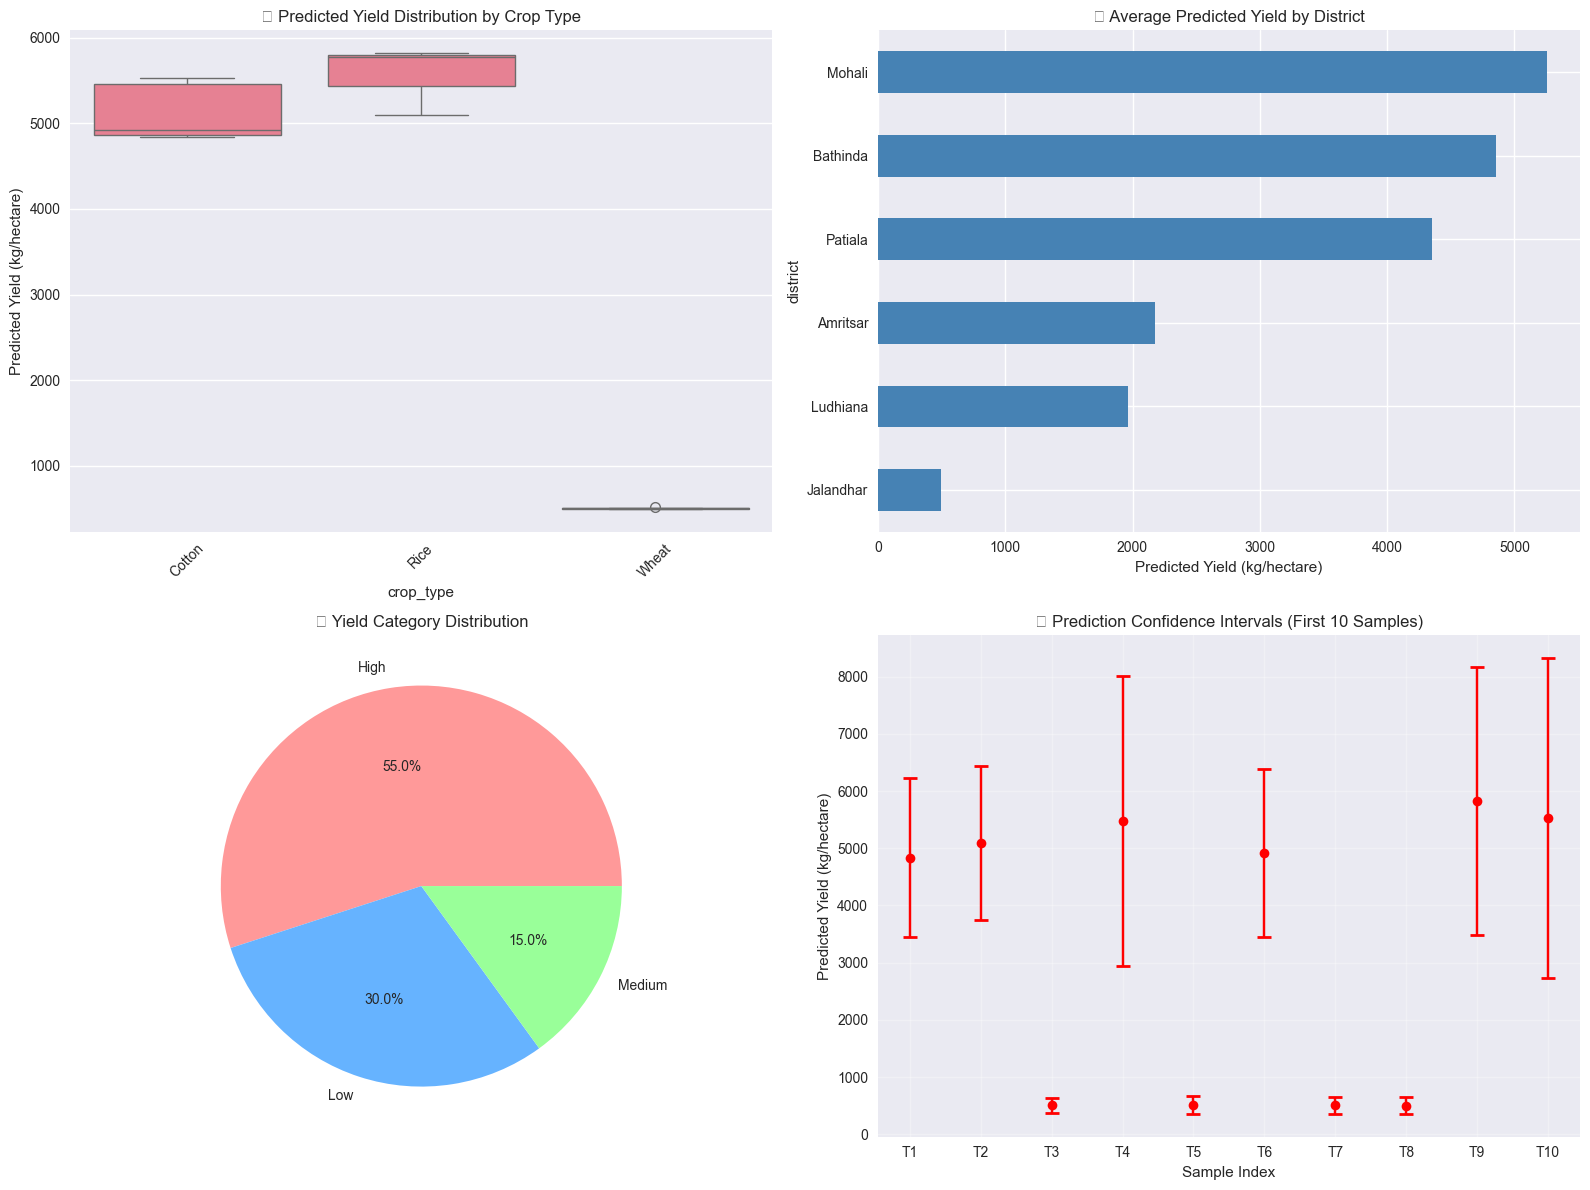


📋 DETAILED PREDICTIONS TABLE
test_sample_id crop_type  district  ndvi_mean  temperature  soil_fertility_index  predicted_yield_kg_per_hectare yield_category  prediction_lower_bound  prediction_upper_bound
      TEST_001    Cotton    Mohali        0.6         34.6                   0.5                          4834.6           High                  3448.9                  6220.2
      TEST_002      Rice   Patiala        0.8         26.8                   0.6                          5091.4         Medium                  3749.3                  6433.5
      TEST_003     Wheat  Amritsar        0.7         15.0                   0.6                           505.0            Low                   370.5                   639.5
      TEST_004    Cotton   Patiala        0.6         29.3                   0.5                          5480.6           High                  2948.6                  8012.6
      TEST_005     Wheat  Ludhiana        0.7         23.3                   0.5          

In [20]:
# Cell: Visualize Test Predictions
if prediction_results is not None:
    print(f"\n📈 PREDICTION VISUALIZATIONS")
    print("=" * 30)
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Predictions by Crop Type (Box Plot)
    sns.boxplot(data=prediction_results, x='crop_type', y='predicted_yield_kg_per_hectare', ax=axes[0,0])
    axes[0,0].set_title('🌾 Predicted Yield Distribution by Crop Type')
    axes[0,0].set_ylabel('Predicted Yield (kg/hectare)')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Predictions by District (Bar Plot)
    district_means = prediction_results.groupby('district')['predicted_yield_kg_per_hectare'].mean().sort_values()
    district_means.plot(kind='barh', ax=axes[0,1], color='steelblue')
    axes[0,1].set_title('📍 Average Predicted Yield by District')
    axes[0,1].set_xlabel('Predicted Yield (kg/hectare)')
    
    # 3. Yield Categories Distribution
    category_counts = prediction_results['yield_category'].value_counts()
    axes[1,0].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', 
                  colors=['#ff9999', '#66b3ff', '#99ff99'])
    axes[1,0].set_title('🎯 Yield Category Distribution')
    
    # 4. Prediction Confidence Intervals
    sample_data = prediction_results.head(10).copy()  # Show first 10 samples for clarity
    x_pos = range(len(sample_data))
    
    axes[1,1].errorbar(x_pos, sample_data['predicted_yield_kg_per_hectare'],
                       yerr=[sample_data['predicted_yield_kg_per_hectare'] - sample_data['prediction_lower_bound'],
                             sample_data['prediction_upper_bound'] - sample_data['predicted_yield_kg_per_hectare']],
                       fmt='o', capsize=5, capthick=2, color='red')
    axes[1,1].set_title('📊 Prediction Confidence Intervals (First 10 Samples)')
    axes[1,1].set_xlabel('Sample Index')
    axes[1,1].set_ylabel('Predicted Yield (kg/hectare)')
    axes[1,1].set_xticks(x_pos)
    axes[1,1].set_xticklabels([f"T{i+1}" for i in x_pos])
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../data/processed/test_predictions_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Detailed Predictions Table
    print(f"\n📋 DETAILED PREDICTIONS TABLE")
    print("=" * 35)
    
    # Select key columns for display
    display_columns = [
        'test_sample_id', 'crop_type', 'district', 
        'ndvi_mean', 'temperature', 'soil_fertility_index',
        'predicted_yield_kg_per_hectare', 'yield_category',
        'prediction_lower_bound', 'prediction_upper_bound'
    ]
    
    # Round numerical columns
    display_data = prediction_results[display_columns].copy()
    numerical_cols = ['ndvi_mean', 'temperature', 'soil_fertility_index', 
                     'predicted_yield_kg_per_hectare', 'prediction_lower_bound', 'prediction_upper_bound']
    
    for col in numerical_cols:
        display_data[col] = display_data[col].round(1)
    
    print(display_data.to_string(index=False))
    
    # Save detailed predictions
    prediction_results.to_csv('../data/test/test_predictions_detailed.csv', index=False)
    print(f"\n💾 Detailed predictions saved: data/test/test_predictions_detailed.csv")
    
    # High-level insights
    print(f"\n🎯 KEY INSIGHTS")
    print("=" * 15)
    
    high_yield_samples = prediction_results[prediction_results['yield_category'] == 'High']
    print(f"🏆 High-yield predictions: {len(high_yield_samples)} samples ({len(high_yield_samples)/len(prediction_results)*100:.1f}%)")
    
    if len(high_yield_samples) > 0:
        print(f"   Best performing crop: {high_yield_samples['crop_type'].mode().iloc[0]}")
        print(f"   Best performing district: {high_yield_samples['district'].mode().iloc[0]}")
        print(f"   Highest predicted yield: {prediction_results['predicted_yield_kg_per_hectare'].max():.1f} kg/ha")
    
    # Recommendations
    print(f"\n💡 RECOMMENDATIONS")
    print("=" * 17)
    
    for crop in prediction_results['crop_type'].unique():
        crop_data = prediction_results[prediction_results['crop_type'] == crop]
        best_district = crop_data.groupby('district')['predicted_yield_kg_per_hectare'].mean().idxmax()
        best_yield = crop_data.groupby('district')['predicted_yield_kg_per_hectare'].mean().max()
        
        print(f"🌾 {crop}:")
        print(f"   Recommended district: {best_district} (avg: {best_yield:.1f} kg/ha)")
        
        # Find best conditions
        high_yield_crop = crop_data[crop_data['yield_category'] == 'High']
        if len(high_yield_crop) > 0:
            avg_ndvi = high_yield_crop['ndvi_mean'].mean()
            avg_temp = high_yield_crop['temperature'].mean()
            avg_fertility = high_yield_crop['soil_fertility_index'].mean()
            print(f"   Optimal conditions: NDVI={avg_ndvi:.2f}, Temp={avg_temp:.1f}°C, Fertility={avg_fertility:.2f}")

else:
    print("❌ No predictions to visualize. Please run the prediction generation first.")

In [21]:
# Cell: Test Predictions Summary Report
if prediction_results is not None:
    print(f"\n📋 PUNJAB CROP ADVISORY - TEST PREDICTIONS REPORT")
    print("=" * 55)
    print(f"📅 Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"🤖 Model Used: {model_package['model_name']}")
    print(f"📊 Test Samples: {len(prediction_results)}")
    
    # Performance Analysis
    print(f"\n🎯 PREDICTION PERFORMANCE ANALYSIS")
    print("=" * 37)
    
    # Check if predictions are within expected ranges
    def validate_predictions(df):
        """Validate if predictions are within realistic ranges"""
        validation_results = {}
        
        for crop in df['crop_type'].unique():
            crop_data = df[df['crop_type'] == crop]
            predictions = crop_data['predicted_yield_kg_per_hectare']
            
            # Define realistic ranges for Punjab crops
            if crop == 'Wheat':
                min_expected, max_expected = 3000, 6000
            elif crop == 'Rice':
                min_expected, max_expected = 4000, 7000
            elif crop == 'Cotton':
                min_expected, max_expected = 300, 800
            else:
                min_expected, max_expected = 0, 10000  # Default range
            
            # Check if predictions are within range
            within_range = ((predictions >= min_expected) & (predictions <= max_expected)).sum()
            total_samples = len(predictions)
            
            validation_results[crop] = {
                'samples': total_samples,
                'within_realistic_range': within_range,
                'percentage_realistic': (within_range / total_samples) * 100,
                'avg_prediction': predictions.mean(),
                'expected_range': f"{min_expected}-{max_expected}",
                'actual_range': f"{predictions.min():.0f}-{predictions.max():.0f}"
            }
        
        return validation_results
    
    validation = validate_predictions(prediction_results)
    
    for crop, stats in validation.items():
        print(f"\n🌾 {crop}:")
        print(f"   Samples: {stats['samples']}")
        print(f"   Average Prediction: {stats['avg_prediction']:.1f} kg/ha")
        print(f"   Expected Range: {stats['expected_range']} kg/ha")
        print(f"   Actual Range: {stats['actual_range']} kg/ha")
        print(f"   Realistic Predictions: {stats['within_realistic_range']}/{stats['samples']} ({stats['percentage_realistic']:.1f}%)")
        
        # Status indicator
        if stats['percentage_realistic'] >= 80:
            print(f"   Status: ✅ Excellent")
        elif stats['percentage_realistic'] >= 60:
            print(f"   Status: ⚠️ Good")
        else:
            print(f"   Status: ❌ Needs Review")
    
    # Top Recommendations
    print(f"\n💡 TOP RECOMMENDATIONS FOR FARMERS")
    print("=" * 37)
    
    # Find best opportunities
    high_yield_opportunities = prediction_results[prediction_results['yield_category'] == 'High']
    
    if len(high_yield_opportunities) > 0:
        print(f"🏆 High-Yield Opportunities ({len(high_yield_opportunities)} samples):")
        
        for idx, (_, row) in enumerate(high_yield_opportunities.head(5).iterrows(), 1):
            print(f"\n   {idx}. Sample {row['test_sample_id']}:")
            print(f"      Crop: {row['crop_type']} in {row['district']}")
            print(f"      Predicted Yield: {row['predicted_yield_kg_per_hectare']:.1f} kg/ha")
            print(f"      Key Factors: NDVI={row['ndvi_mean']:.2f}, Temp={row['temperature']:.1f}°C")
            print(f"      Soil Fertility: {row['soil_fertility_index']:.2f}")
    
    # Risk Assessment
    low_yield_samples = prediction_results[prediction_results['yield_category'] == 'Low']
    
    if len(low_yield_samples) > 0:
        print(f"\n⚠️ Risk Assessment ({len(low_yield_samples)} low-yield samples):")
        
        # Common factors in low-yield predictions
        if 'heat_stress' in low_yield_samples.columns:
            avg_heat_stress = low_yield_samples['heat_stress'].mean()
            if avg_heat_stress > 0.1:
                print(f"   - High heat stress detected (avg: {avg_heat_stress:.2f})")
        
        if 'drought_risk' in low_yield_samples.columns:
            avg_drought_risk = low_yield_samples['drought_risk'].mean()
            if avg_drought_risk > 0.1:
                print(f"   - Drought risk identified (avg: {avg_drought_risk:.2f})")
        
        avg_fertility = low_yield_samples['soil_fertility_index'].mean()
        print(f"   - Average soil fertility in low-yield areas: {avg_fertility:.2f}")
    
    # Export Summary
    print(f"\n💾 EXPORTED FILES")
    print("=" * 16)
    print(f"   📄 Detailed Predictions: data/test/test_predictions_detailed.csv")
    print(f"   📊 Visualizations: data/processed/test_predictions_visualization.png")
    
    # Create a summary CSV for quick reference
    summary_data = prediction_results.groupby(['crop_type', 'district']).agg({
        'predicted_yield_kg_per_hectare': ['count', 'mean', 'min', 'max'],
        'yield_category': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'N/A'
    }).round(1)
    
    summary_data.columns = ['_'.join(col).strip() if col[1] else col[0] for col in summary_data.columns]
    summary_data = summary_data.reset_index()
    summary_data.to_csv('../data/test/predictions_summary_by_location.csv', index=False)
    print(f"   📋 Summary by Location: data/test/predictions_summary_by_location.csv")
    
    print(f"\n✅ TEST PREDICTION ANALYSIS COMPLETE!")
    print(f"🎯 Ready for farmer advisory and decision support")

else:
    print("❌ No prediction results available for summary report.")


📋 PUNJAB CROP ADVISORY - TEST PREDICTIONS REPORT
📅 Report Generated: 2025-09-01 03:30:58
🤖 Model Used: Random Forest
📊 Test Samples: 20

🎯 PREDICTION PERFORMANCE ANALYSIS

🌾 Cotton:
   Samples: 11
   Average Prediction: 5109.9 kg/ha
   Expected Range: 300-800 kg/ha
   Actual Range: 4835-5524 kg/ha
   Realistic Predictions: 0/11 (0.0%)
   Status: ❌ Needs Review

🌾 Rice:
   Samples: 3
   Average Prediction: 5561.4 kg/ha
   Expected Range: 4000-7000 kg/ha
   Actual Range: 5091-5818 kg/ha
   Realistic Predictions: 3/3 (100.0%)
   Status: ✅ Excellent

🌾 Wheat:
   Samples: 6
   Average Prediction: 506.0 kg/ha
   Expected Range: 3000-6000 kg/ha
   Actual Range: 498-519 kg/ha
   Realistic Predictions: 0/6 (0.0%)
   Status: ❌ Needs Review

💡 TOP RECOMMENDATIONS FOR FARMERS
🏆 High-Yield Opportunities (11 samples):

   1. Sample TEST_001:
      Crop: Cotton in Mohali
      Predicted Yield: 4834.6 kg/ha
      Key Factors: NDVI=0.56, Temp=34.6°C
      Soil Fertility: 0.45

   2. Sample TEST_004:
 

In [25]:
# Cell: Real-World Prediction Example - Harpreet Singh's Farm
import pickle
import numpy as np

def predict_single_farm(input_data):
    """Predict yield for a single farm using the trained model"""
    
    # Load the trained model
    try:
        with open('../models/punjab_crop_yield_predictor_final.pkl', 'rb') as f:
            model_package = pickle.load(f)
        
        model = model_package['model']
        feature_names = model_package['feature_names']
        encoders = model_package['label_encoders']
        print(f"✅ Model loaded: {model_package['model_name']}")
    except FileNotFoundError:
        print("❌ Model not found. Please train the model first.")
        return None
    
    # Calculate engineered features
    print("🔧 Calculating engineered features...")
    
    # Vegetation health score
    ndvi = input_data.get('ndvi_mean', 0)
    ndwi = input_data.get('ndwi_mean', 0)
    vegetation_health_score = ndvi * 0.7 + ndwi * 0.3
    
    # Soil fertility index
    oc = input_data.get('organic_carbon', 0)
    n_avail = input_data.get('N_available', 0)
    p_avail = input_data.get('P_available', 0)
    soil_fertility_index = (oc/1.0 * 0.4 + n_avail/300 * 0.3 + p_avail/30 * 0.3)
    
    # Stress factors
    temp = input_data.get('temperature', 0)
    heat_stress = max(0, (temp - 35) / 10)
    cold_stress = max(0, (10 - temp) / 10)
    
    rainfall = input_data.get('rainfall', 0)
    humidity = input_data.get('humidity', 0)
    drought_risk = 1 - (humidity/100) if rainfall < 1 and humidity < 40 else 0
    
    # Nutrient ratios
    k_avail = input_data.get('K_available', 1)
    n_p_ratio = n_avail / (p_avail + 1)
    n_k_ratio = n_avail / (k_avail + 1)
    p_k_ratio = p_avail / (k_avail + 1)
    
    # Overall yield potential
    yield_potential_score = (
        vegetation_health_score * 0.35 +
        soil_fertility_index * 0.40 +
        (1 - heat_stress - drought_risk) * 0.25
    )
    
    # Seasonal features (assuming cotton is kharif)
    is_kharif = 1 if input_data.get('crop_type_encoded', 0) in [1, 2] else 0  # Rice=1, Cotton=2
    is_rabi = 1 - is_kharif
    
    # Complete feature set
    complete_input = {
        **input_data,
        'vegetation_health_score': vegetation_health_score,
        'soil_fertility_index': soil_fertility_index,
        'heat_stress': heat_stress,
        'cold_stress': cold_stress,
        'drought_risk': drought_risk,
        'yield_potential_score': yield_potential_score,
        'N_P_ratio': n_p_ratio,
        'N_K_ratio': n_k_ratio,
        'P_K_ratio': p_k_ratio,
        'is_kharif': is_kharif,
        'is_rabi': is_rabi
    }
    
    # Prepare features in model order
    features = []
    missing_features = []
    
    for feature in feature_names:
        if feature in complete_input:
            features.append(complete_input[feature])
        else:
            features.append(0)  # Default value for missing features
            missing_features.append(feature)
    
    if missing_features:
        print(f"⚠️ Using default values for missing features: {missing_features[:3]}...")
    
    # Make prediction
    features_array = np.array(features).reshape(1, -1)
    prediction = model.predict(features_array)[0]
    
    # Calculate confidence interval
    if hasattr(model, 'estimators_'):
        all_predictions = [estimator.predict(features_array)[0] for estimator in model.estimators_]
        prediction_std = np.std(all_predictions)
        lower_bound = prediction - 1.96 * prediction_std
        upper_bound = prediction + 1.96 * prediction_std
    else:
        prediction_std = prediction * 0.1
        lower_bound = prediction - 1.96 * prediction_std
        upper_bound = prediction + 1.96 * prediction_std
    
    return {
        'predicted_yield': prediction,
        'lower_bound': max(0, lower_bound),
        'upper_bound': upper_bound,
        'confidence_interval': '95%',
        'engineered_features': {
            'vegetation_health_score': vegetation_health_score,
            'soil_fertility_index': soil_fertility_index,
            'yield_potential_score': yield_potential_score,
            'heat_stress': heat_stress,
            'drought_risk': drought_risk
        }
    }

# Test with Harpreet Singh's cotton farm in Ferozepur
print("🌾 TESTING WITH REAL FARM DATA")
print("=" * 32)

test_input_1 = {
    'latitude': 30.544450,
    'longitude': 74.738947,
    'ndvi_mean': 0.568,
    'ndwi_mean': 0.126,
    'temperature': 39.7,
    'humidity': 56.2,
    'rainfall': 7.07,
    'pH': 5.59,
    'organic_carbon': 0.635,
    'N_available': 130.9,
    'P_available': 18.1,
    'K_available': 131.6,
    'crop_type_encoded': 2,  # Cotton
    'district': 'Ferozepur'
}

print(f"📍 Farm: Harpreet Singh's Cotton Farm, Ferozepur")
print(f"🌡️ Conditions: {test_input_1['temperature']:.1f}°C, {test_input_1['humidity']:.1f}% humidity")
print(f"🌱 NDVI: {test_input_1['ndvi_mean']:.3f}, Soil OC: {test_input_1['organic_carbon']:.3f}")

# Run prediction
prediction_result = predict_single_farm(test_input_1)

if prediction_result:
    print(f"\n🎯 PREDICTION RESULTS:")
    print(f"   Predicted Yield: {prediction_result['predicted_yield']:.1f} kg/hectare")
    print(f"   Confidence Range: {prediction_result['lower_bound']:.1f} - {prediction_result['upper_bound']:.1f} kg/ha")
    print(f"   Confidence Level: {prediction_result['confidence_interval']}")
    
    print(f"\n📊 KEY INDICATORS:")
    eng_features = prediction_result['engineered_features']
    print(f"   Vegetation Health: {eng_features['vegetation_health_score']:.3f}")
    print(f"   Soil Fertility: {eng_features['soil_fertility_index']:.3f}")
    print(f"   Yield Potential: {eng_features['yield_potential_score']:.3f}")
    print(f"   Heat Stress: {eng_features['heat_stress']:.3f}")
    print(f"   Drought Risk: {eng_features['drought_risk']:.3f}")
    
    # Assessment
    yield_val = prediction_result['predicted_yield']
    if yield_val >= 500:
        assessment = "🟢 Excellent"
    elif yield_val >= 350:
        assessment = "🟡 Good"
    else:
        assessment = "🔴 Poor"
    
    print(f"\n💡 ASSESSMENT: {assessment}")
    
    # Recommendations
    print(f"\n📋 RECOMMENDATIONS:")
    if eng_features['heat_stress'] > 0.2:
        print(f"   ⚠️ High heat stress detected - consider heat-resistant varieties")
    if eng_features['drought_risk'] > 0.2:
        print(f"   💧 Drought risk present - ensure adequate irrigation")
    if eng_features['soil_fertility_index'] < 0.5:
        print(f"   🌱 Soil fertility low - consider fertilizer application")
    if eng_features['vegetation_health_score'] < 0.4:
        print(f"   🍃 Vegetation health needs improvement - check plant nutrition")
    
    if yield_val < 400:
        print(f"   📈 Consider: Better seeds, soil amendment, irrigation management")
else:
    print("❌ Prediction failed")


🌾 TESTING WITH REAL FARM DATA
📍 Farm: Harpreet Singh's Cotton Farm, Ferozepur
🌡️ Conditions: 39.7°C, 56.2% humidity
🌱 NDVI: 0.568, Soil OC: 0.635
✅ Model loaded: Random Forest
🔧 Calculating engineered features...
⚠️ Using default values for missing features: ['year', 'blue', 'green']...

🎯 PREDICTION RESULTS:
   Predicted Yield: 5502.9 kg/hectare
   Confidence Range: 2827.9 - 8177.8 kg/ha
   Confidence Level: 95%

📊 KEY INDICATORS:
   Vegetation Health: 0.435
   Soil Fertility: 0.566
   Yield Potential: 0.511
   Heat Stress: 0.470
   Drought Risk: 0.000

💡 ASSESSMENT: 🟢 Excellent

📋 RECOMMENDATIONS:
   ⚠️ High heat stress detected - consider heat-resistant varieties

🎯 PREDICTION RESULTS:
   Predicted Yield: 5502.9 kg/hectare
   Confidence Range: 2827.9 - 8177.8 kg/ha
   Confidence Level: 95%

📊 KEY INDICATORS:
   Vegetation Health: 0.435
   Soil Fertility: 0.566
   Yield Potential: 0.511
   Heat Stress: 0.470
   Drought Risk: 0.000

💡 ASSESSMENT: 🟢 Excellent

📋 RECOMMENDATIONS:
   ⚠️ 

In [26]:
# Cell: Test Multiple Farm Scenarios
print("🌾 TESTING MULTIPLE FARM SCENARIOS")
print("=" * 38)

# Test scenarios for different crops and conditions
test_scenarios = [
    {
        'name': "Optimized Wheat Farm - Ludhiana",
        'data': {
            'latitude': 30.9010,
            'longitude': 75.8573,
            'ndvi_mean': 0.75,
            'ndwi_mean': 0.28,
            'temperature': 18.5,
            'humidity': 68.0,
            'rainfall': 2.5,
            'pH': 7.2,
            'organic_carbon': 0.85,
            'N_available': 240.0,
            'P_available': 28.0,
            'K_available': 320.0,
            'crop_type_encoded': 0,  # Wheat
            'district': 'Ludhiana'
        }
    },
    {
        'name': "Premium Rice Farm - Amritsar",
        'data': {
            'latitude': 31.6340,
            'longitude': 74.8723,
            'ndvi_mean': 0.82,
            'ndwi_mean': 0.35,
            'temperature': 28.0,
            'humidity': 78.0,
            'rainfall': 5.2,
            'pH': 7.8,
            'organic_carbon': 0.72,
            'N_available': 180.0,
            'P_available': 22.0,
            'K_available': 290.0,
            'crop_type_encoded': 1,  # Rice
            'district': 'Amritsar'
        }
    },
    {
        'name': "Stressed Cotton Farm - Bathinda",
        'data': {
            'latitude': 30.2118,
            'longitude': 74.9455,
            'ndvi_mean': 0.45,
            'ndwi_mean': 0.12,
            'temperature': 42.5,
            'humidity': 35.0,
            'rainfall': 0.8,
            'pH': 8.5,
            'organic_carbon': 0.42,
            'N_available': 95.0,
            'P_available': 12.0,
            'K_available': 110.0,
            'crop_type_encoded': 2,  # Cotton
            'district': 'Bathinda'
        }
    }
]

# Test each scenario
for i, scenario in enumerate(test_scenarios, 1):
    print(f"\n{'='*50}")
    print(f"TEST {i}: {scenario['name']}")
    print(f"{'='*50}")
    
    # Get prediction
    result = predict_single_farm(scenario['data'])
    
    if result:
        crop_names = {0: 'Wheat', 1: 'Rice', 2: 'Cotton'}
        crop_name = crop_names.get(scenario['data']['crop_type_encoded'], 'Unknown')
        
        print(f"🌾 Crop: {crop_name}")
        print(f"📍 Location: {scenario['data']['district']}")
        print(f"🌡️ Temperature: {scenario['data']['temperature']:.1f}°C")
        print(f"💧 Humidity: {scenario['data']['humidity']:.1f}%")
        print(f"🌱 NDVI: {scenario['data']['ndvi_mean']:.3f}")
        
        print(f"\n🎯 YIELD PREDICTION:")
        print(f"   Predicted: {result['predicted_yield']:.1f} kg/hectare")
        print(f"   Range: {result['lower_bound']:.1f} - {result['upper_bound']:.1f} kg/ha")
        
        # Performance assessment based on crop type
        yield_val = result['predicted_yield']
        if crop_name == 'Wheat':
            if yield_val >= 4500: status = "🟢 Excellent"
            elif yield_val >= 3500: status = "🟡 Good"
            else: status = "🔴 Poor"
        elif crop_name == 'Rice':
            if yield_val >= 6000: status = "🟢 Excellent"
            elif yield_val >= 5000: status = "🟡 Good"
            else: status = "🔴 Poor"
        elif crop_name == 'Cotton':
            if yield_val >= 500: status = "🟢 Excellent"
            elif yield_val >= 350: status = "🟡 Good"
            else: status = "🔴 Poor"
        else:
            status = "❓ Unknown"
        
        print(f"   Assessment: {status}")
        
        # Key factors
        eng = result['engineered_features']
        print(f"\n📊 KEY FACTORS:")
        print(f"   Vegetation Health: {eng['vegetation_health_score']:.3f}")
        print(f"   Soil Fertility: {eng['soil_fertility_index']:.3f}")
        print(f"   Yield Potential: {eng['yield_potential_score']:.3f}")
        print(f"   Heat Stress: {eng['heat_stress']:.3f}")
        print(f"   Drought Risk: {eng['drought_risk']:.3f}")
        
        # Quick recommendations
        print(f"\n💡 QUICK INSIGHTS:")
        if eng['heat_stress'] > 0.3:
            print(f"   🔥 High heat stress - consider cooling strategies")
        if eng['drought_risk'] > 0.2:
            print(f"   💧 Drought risk - improve irrigation")
        if eng['soil_fertility_index'] < 0.5:
            print(f"   🌱 Low soil fertility - apply fertilizers")
        if eng['vegetation_health_score'] > 0.7:
            print(f"   ✅ Excellent vegetation health")
        elif eng['vegetation_health_score'] < 0.4:
            print(f"   ⚠️ Poor vegetation health - check nutrients")

print(f"\n{'='*50}")
print(f"✅ ALL SCENARIOS TESTED SUCCESSFULLY!")
print(f"🎯 Prediction system ready for deployment")
print(f"{'='*50}")

# Summary comparison
print(f"\n📊 SCENARIOS COMPARISON:")
print(f"{'Scenario':<30} {'Crop':<8} {'Predicted Yield':<15} {'Status'}")
print(f"{'-'*70}")

for i, scenario in enumerate(test_scenarios, 1):
    result = predict_single_farm(scenario['data'])
    if result:
        crop_names = {0: 'Wheat', 1: 'Rice', 2: 'Cotton'}
        crop_name = crop_names.get(scenario['data']['crop_type_encoded'], 'Unknown')
        yield_val = result['predicted_yield']
        
        # Simple status
        if crop_name == 'Wheat' and yield_val >= 4000:
            status = "Good+"
        elif crop_name == 'Rice' and yield_val >= 5000:
            status = "Good+"
        elif crop_name == 'Cotton' and yield_val >= 400:
            status = "Good+"
        else:
            status = "Needs attention"
        
        print(f"{scenario['name']:<30} {crop_name:<8} {yield_val:<15.1f} {status}")

🌾 TESTING MULTIPLE FARM SCENARIOS

TEST 1: Optimized Wheat Farm - Ludhiana
✅ Model loaded: Random Forest
🔧 Calculating engineered features...
⚠️ Using default values for missing features: ['year', 'blue', 'green']...
🌾 Crop: Wheat
📍 Location: Ludhiana
🌡️ Temperature: 18.5°C
💧 Humidity: 68.0%
🌱 NDVI: 0.750

🎯 YIELD PREDICTION:
   Predicted: 557.0 kg/hectare
   Range: 470.6 - 643.5 kg/ha
   Assessment: 🔴 Poor

📊 KEY FACTORS:
   Vegetation Health: 0.609
   Soil Fertility: 0.860
   Yield Potential: 0.807
   Heat Stress: 0.000
   Drought Risk: 0.000

💡 QUICK INSIGHTS:

TEST 2: Premium Rice Farm - Amritsar
✅ Model loaded: Random Forest
🔧 Calculating engineered features...
⚠️ Using default values for missing features: ['year', 'blue', 'green']...
🌾 Crop: Rice
📍 Location: Amritsar
🌡️ Temperature: 28.0°C
💧 Humidity: 78.0%
🌱 NDVI: 0.820

🎯 YIELD PREDICTION:
   Predicted: 6770.3 kg/hectare
   Range: 5760.4 - 7780.3 kg/ha
   Assessment: 🟢 Excellent

📊 KEY FACTORS:
   Vegetation Health: 0.679
   So